In [1]:
pip install --upgrade transformers==4.30.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.1
    Uninstalling transformers-4.40.1:
      Successfully uninstalled transformers-4.40.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd
import datetime as dt
import numpy as np
import os
def change_dolar(local_value:float,
    change_rate:float):
  return local_value*change_rate




path_change=r"/content/drive/MyDrive/Hack Corruption - Contractor/datos/Tasa_cambio.xlsx"
path_data=r"/content/drive/MyDrive/Hack Corruption - Contractor/datos/records.csv"
path_CPI=r"/content/drive/MyDrive/Hack Corruption - Contractor/datos/USA_CPI.xlsx"
path_data_gener=r"/content/drive/MyDrive/Hack Corruption - Contractor/datos/zips/"

n=0

for path in os.listdir(path_data_gener):


  #Loading the exchange rate for USD standaricing
  exchange_rate=pd.read_excel(path_change)
  exchange_rate["exchange_rate"]=exchange_rate.apply(lambda row:(row["Máximo"]+row["Mínimo"])/2,
                                            axis=1)
  exchange_rate=exchange_rate[["Fecha","exchange_rate"]]

  #Loading the dataset  and cleaning dates
  records=pd.read_csv(path_data_gener+path)
  records=records.dropna(subset="compiledRelease/tender/bidOpening/date")


  records["Fecha"]=records["compiledRelease/tender/bidOpening/date"].apply(
      lambda x:dt.datetime.strptime(x[:10],"%Y-%m-%d").year
  )

  #Loading CPI for real value updating
  CPI=pd.read_excel(path_CPI)
  CPI=CPI[["Year","Avg"]].dropna()
  last_year=CPI["Avg"][len(CPI)-1]

  #merging tables
  records=records.merge(exchange_rate,how="left",on=["Fecha"])

  #We use the last inflation data and normalize everything to the last year
  records=records.merge(CPI,how="left",left_on=["Fecha"],right_on=["Year"])
  records["Avg"]=records["Avg"].fillna(last_year).apply(lambda x:x/last_year)

  #We scale every value in million dolars
  records["value_million_dolar"]=records.apply(lambda row:row["compiledRelease/tender/value/amount"]/(row["exchange_rate"]*row["Avg"]*1e3)
                                      if row["compiledRelease/tender/value/currency"]=="PYG" else row["compiledRelease/tender/value/amount"]/(row["Avg"]*1e3),axis=1)

  if n==0:
    joined=records
  else:
    joined=joined.append(records)


joined=joined.dropna(subset=["compiledRelease/planning/budget/description","value_million_dolar"])


<ipython-input-16-4527da2c5dd1>:29: DtypeWarning: Columns (60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  records=pd.read_csv(path_data_gener+path)
<ipython-input-16-4527da2c5dd1>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records["Fecha"]=records["compiledRelease/tender/bidOpening/date"].apply(
<ipython-input-16-4527da2c5dd1>:29: DtypeWarning: Columns (60,61,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  records=pd.read_csv(path_data_gener+path)
<ipython-input-16-4527da2c5dd1>:29: DtypeWarning: Columns (64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  records=pd.read_csv(path_data_gener+path)
<ipython-input-16-4527da2c5dd1>:29: 

In [8]:
joined['compiledRelease/tender/mainProcurementCategory']


0        services
4        services
6        services
8        services
10       services
           ...   
22998    services
23000    services
23001    services
23018    services
23030    services
Name: compiledRelease/tender/mainProcurementCategory, Length: 5282, dtype: object

In [9]:
#Declaramos las variables que vamos a usar en predicción
variables_y=["value_million_dolar"]
variables_cat=["compiledRelease/tender/awardCriteria","compiledRelease/tender/status",
               "compiledRelease/tender/mainProcurementCategory","compiledRelease/tender/numberOfTenderers",
               "compiledRelease/tender/procurementIntention/category",
               "compiledRelease/tender/submissionMethod","compiledRelease/tender/awardCriteriaDetails",
               'compiledRelease/tender/mainProcurementCategoryDetails',
               'compiledRelease/tender/hasEnquiries','compiledRelease/planning/budget/amount/currency']
variables_reg=["compiledRelease/tender/enquiryPeriod/durationInDays"]
variables_text=["compiledRelease/planning/budget/description"]


In [10]:
joined['compiledRelease/planning/budget/amount/currency']

0        PYG
4        PYG
6        PYG
8        PYG
10       PYG
        ... 
22998    PYG
23000    PYG
23001    PYG
23018    PYG
23030    PYG
Name: compiledRelease/planning/budget/amount/currency, Length: 5282, dtype: object

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 10 15:13:07 2023

@author: usuario
"""

import pandas as pd

import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm

casa=joined[variables_text+variables_y]
casa[variables_y]=casa[variables_y].astype(int)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class BertDataset(Dataset):
    def __init__(self, tokenizer,max_length):
        super(BertDataset, self).__init__()
        self.train_csv=casa
        self.tokenizer=tokenizer
        self.target=self.train_csv.iloc[:,1]
        self.max_length=max_length

    def __len__(self):
        return len(self.train_csv)

    def __getitem__(self, index):

        text1 = self.train_csv.iloc[index,0]

        inputs = self.tokenizer.encode_plus(
            text1 ,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long).to(device),
            'mask': torch.tensor(mask, dtype=torch.long).to(device),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long).to(device),
            'target': torch.tensor(self.train_csv.iloc[index, 1], dtype=torch.int).to(device)
            }
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-multilingual-cased")

dataset= BertDataset(tokenizer, max_length=100)
batch_size=64
dataloader=DataLoader(dataset=dataset,batch_size=batch_size)

class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained("bert-base-multilingual-cased")
        self.medium2 = nn.Linear(768, 15000)
        self.medium3 = nn.ReLU()
        self.medium4=nn.Linear(15000,15000,bias=True)
        self.medium5 = nn.Sigmoid()
        self.medium6=nn.Linear(15000,1500,bias=True)
        self.medium7 = nn.Sigmoid()
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(1500, 1,bias=True)
        self.l1_strength=0.00003

    def forward(self,ids,mask,token_type_ids):
        _,o2= self.bert_model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
        medium2=self.medium2(o2)
        medium3=self.medium3(medium2)
        medium4=self.medium4(medium3)
        medium5=self.medium5(medium4)
        medium6=self.medium5(medium4)
        medium7=self.medium6(medium5)
        medium8=self.drop(medium7)
        out= self.out(medium8)
        return medium7

    def l1_regularization(self):
        n=0
        l1_loss_example = 0
        #the next structure is to only recognize the layers that are finetuned
        #this makes the exercise faster and allows to update the strength easier
        for param in self.parameters():
            n+=1
            if n>197:
                l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * (l1_loss_example)

model=BERT()





def predict(epochs,dataloader,model,loss_fn,optimizer):
    num=1
    acc=0
    loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
    results=[]
    for batch, dl in loop:
      ids=dl['ids']
      token_type_ids=dl['token_type_ids']
      mask= dl['mask']
      label=dl['target']
      label = label.unsqueeze(1)

      optimizer.zero_grad()

      output=model(
          ids=ids,
          mask=mask,
          token_type_ids=token_type_ids)
      label = label.type_as(output)
      for i in output.cpu().detach().numpy():
          results.append(i)


    print(acc/num)


    return results



model.load_state_dict(torch.load(r"/content/drive/MyDrive/Hack Corruption - Contractor/modelos/primero.pt"))



model.to(device)

loss_fn = nn.L1Loss()

#Initialize Optimizer
optimizer= optim.Adam(model.parameters(),lr= 1e-5)


<ipython-input-11-a3703c086873>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  casa[variables_y]=casa[variables_y].astype(int)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
loss_fn = nn.L1Loss()

#Initialize Optimizer
optimizer= optim.Adam(model.parameters(),lr= 1e-5)

predicted=pd.DataFrame(predict(100000, dataloader, model, loss_fn, optimizer))

  0%|          | 0/83 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


0.0


In [13]:
data_categ=predicted.merge(pd.get_dummies(joined[variables_cat].reset_index(drop=True).astype("str")),left_index=True, right_index=True)

In [19]:
import pandas as pd


from sklearn.metrics import r2_score
import json

import pickle
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#this will be later transplanted to the main file, but for now I need to test
#the code somewhere and tdidn´t find a better place
#some paths to where things are


#this cant be change, they are how rn where train (will be changed manually)



#takes only the regresive variables

joined=joined[joined['compiledRelease/tender/mainProcurementCategory']=="services"]
data_value=joined[variables_y]



data_categ_train, data_categ_test, data_value_train, data_value_test = train_test_split(
     data_categ, data_value, test_size=0.15, random_state=1,shuffle=True)

dtrain_reg = xgb.DMatrix(data_categ_train, data_value_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(data_categ_test, data_value_test, enable_categorical=True)
pure_data = xgb.DMatrix(data_categ, data_value, enable_categorical=True)


if False:
    n = 20000
    params = {"objective": "reg:pseudohubererror","reg_alpha":50,"reg_lambda":50
              ,"rate_drop":0.1}
    evals = [(dtest_reg, "validation"),(dtrain_reg, "train") ]
    reg = xgb.train(
       params=params,
       dtrain=dtrain_reg,
       num_boost_round=n,
       evals=evals,
       verbose_eval=25,
       early_stopping_rounds=30
       )
    pickle.dump(reg, open(r'/content/drive/MyDrive/Hack Corruption - Contractor/modelos/modelxgboost.pkl','wb'))
else:
    with open(r"/content/drive/MyDrive/Hack Corruption - Contractor/modelos/modelxgboost.pkl", "rb") as input_file:
      reg = pickle.load(input_file)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:15:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "rate_drop" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-mphe:216.55318	train-mphe:163.73634
[25]	validation-mphe:198.84267	train-mphe:145.36909
[50]	validation-mphe:195.95157	train-mphe:142.18877
[75]	validation-mphe:194.07712	train-mphe:140.17438
[100]	validation-mphe:192.77404	train-mphe:138.80268
[125]	validation-mphe:191.73153	train-mphe:137.70416
[150]	validation-mphe:190.80951	train-mphe:136.73736
[175]	validation-mphe:189.99566	train-mphe:135.79416
[200]	validation-mphe:189.33386	train-mphe:135.08191
[225]	validation-mphe:188.79725	train-mphe:134.51361
[250]	validation-mphe:188.29010	train-mphe:133.96237
[275]	validation-mphe:187.93478	train-mphe:133.60983
[300]	validation-mphe:187.54921	train-mphe:133.20440
[325]	validation-mphe:187.23839	train-mphe:132.86497
[350]	validation-mphe:186.97394	train-mphe:132.59098
[375]	validation-mphe:186.72478	train-mphe:132.31987
[400]	validation-mphe:186.58300	train-mphe:132.12357
[425]	validation-mphe:186.37547	train-mphe:131.89882
[450]	validation-mphe:186.16117	train-mphe:131.6529

In [20]:



predict=reg.predict(pure_data)


joined["predict"]=predict

In [21]:
joined

,Open Contracting ID,compiledRelease/id,compiledRelease/tender/id,compiledRelease/tender/title,compiledRelease/tender/status,compiledRelease/tender/awardCriteria,compiledRelease/tender/awardCriteriaDetails,compiledRelease/tender/submissionMethod,compiledRelease/tender/techniques/hasElectronicAuction,compiledRelease/tender/bidOpening/date,...,compiledRelease/secondStage/id,compiledRelease/tender/techniques/hasFrameworkAgreement,compiledRelease/tender/contractPeriod/startDate,compiledRelease/tender/contractPeriod/endDate,Fecha,exchange_rate,Year,Avg,value_million_dolar,predict
0,ocds-03ad3f-326319-1,326319-lpn-sbe-128-17-contratacion-servicios-m...,326319-lpn-sbe-128-17-contratacion-servicios-m...,LPN SBE 128-17 CONTRATACION DE SERVICIOS DE MA...,complete,priceOnly,Por Total,electronicAuction,True,2018-01-23T09:00:00-04:00,...,NaN,NaN,NaN,NaN,2018,5746.19,2018.0,0.858031,271.268706,104.707550
4,ocds-03ad3f-341654-1,341654-contratacion-servicio-mantenimiento-rep...,341654-contratacion-servicio-mantenimiento-rep...,CONTRATACIÓN DE SERVICIO DE MANTENIMIENTO Y RE...,complete,priceOnly,Por Lote,inPerson,NaN,2018-05-07T10:00:00-04:00,...,NaN,NaN,NaN,NaN,2018,5746.19,2018.0,0.858031,642.747446,383.008942
6,ocds-03ad3f-355712-1,355712-contratacion-servicios-publicidad-medio...,355712-contratacion-servicios-publicidad-medio...,CONTRATACIÓN DE SERVICIOS DE PUBLICIDAD EN MED...,complete,priceOnly,Por Lote,inPerson,NaN,2019-03-27T09:00:00-04:00,...,NaN,NaN,NaN,NaN,2019,6216.97,2019.0,0.873578,182.286574,123.583206
8,ocds-03ad3f-371873-1,371873-mantenimiento-reparaciones-dependencias...,371873-mantenimiento-reparaciones-dependencias...,Mantenimiento y Reparaciones de Dependencias d...,complete,priceOnly,Por Total,inPerson,NaN,2019-12-02T09:15:00-04:00,...,NaN,NaN,NaN,NaN,2019,6216.97,2019.0,0.873578,257.778994,338.210724
10,ocds-03ad3f-375498-1,375498-mantenimiento-reparacion-motores-electr...,375498-mantenimiento-reparacion-motores-electr...,MANTENIMIENTO Y REPARACIÓN DE MOTORES ELÉCTRIC...,complete,priceOnly,Por Lote,inPerson,NaN,2020-10-21T09:30:00-04:00,...,NaN,NaN,NaN,NaN,2020,6742.37,2020.0,0.884355,530.450910,521.544556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22998,ocds-03ad3f-383165-1,383165-proyecto-ejecutivo-sistema-climatizacio...,383165-proyecto-ejecutivo-sistema-climatizacio...,PROYECTO EJECUTIVO DEL SISTEMA DE CLIMATIZACIO...,complete,ratedCriteria,Por Total,inPerson,NaN,2020-07-17T10:00:00-04:00,...,NaN,NaN,NaN,NaN,2020,6742.37,2020.0,0.884355,73.792685,44.011719
23000,ocds-03ad3f-383344-1,383344-provison-almuerzo-escolar-modalidad-ali...,383344-provison-almuerzo-escolar-modalidad-ali...,Provisón de Almuerzo Escolar en la Modalidad d...,complete,priceOnly,Por Total,inPerson,NaN,2020-09-04T08:00:00-04:00,...,NaN,NaN,NaN,NaN,2020,6742.37,2020.0,0.884355,145.010884,65.988274
23001,ocds-03ad3f-383408-1,383408-provision-almuerzo-escolar-modalidad-al...,383408-provision-almuerzo-escolar-modalidad-al...,"PROVISION DE ALMUERZO ESCOLAR, BAJO LA MODALID...",complete,priceOnly,Por Total,inPerson,NaN,2020-07-20T07:50:00-04:00,...,NaN,NaN,NaN,NaN,2020,6742.37,2020.0,0.884355,71.889505,40.683491
23018,ocds-03ad3f-384187-1,384187-servicio-imagenes-satelites-cartografia...,384187-servicio-imagenes-satelites-cartografia...,SERVICIO DE IMÁGENES DE SATÉLITES PARA CARTOGR...,complete,priceOnly,Por Total,inPerson,NaN,2020-11-25T10:15:00-04:00,...,NaN,NaN,NaN,NaN,2020,6742.37,2020.0,0.884355,128.298645,36.827244


0.9252177205603938
Help on method pdf in module scipy.stats._distn_infrastructure:

pdf(x) method of scipy.stats._distn_infrastructure.rv_continuous_frozen instance

0.4451789662326978
0.4582095215674891
0.4715002441633283
0.4850440946286705
0.49883278245743107
0.512856698609349
0.5271048502802328
0.5415647987044965
0.5562226009027003
0.5710627563531422
0.5860681596270158
0.6012200600792524
0.6164980297296707
0.631879940499154
0.6473419519808902
0.6628585109247701
0.6784023635915108
0.6939445820896541
0.7094546057412163
0.7249002984286917
0.740248022755916
0.7554627317071245
0.7705080783120996
0.7853465436209819
0.799939583061344
0.8142477909944851
0.8282310830105865
0.84184889520721
0.8550603993874211
0.8678247327982489
0.8801012407137095
0.8918497298563783
0.9030307303551405
0.9136057636622846
0.9235376136085703
0.9327905975682241
0.941330834544422
0.9491265068764173
0.9561481122177873
0.9623687024456833
0.9677641062364114
0.97231313218434
0.9759977495483889
0.9788032439807055
0.9807

<Axes: >

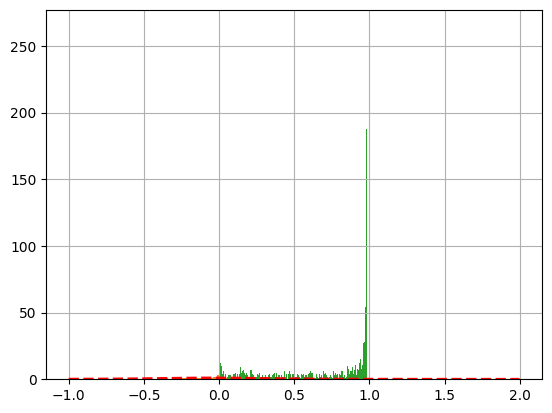

In [22]:

import pandas as pd
from scipy.stats import norm
from scipy import stats

data1=joined

size=2

data1["range-"]=data1["predict"].apply(lambda x:x*(1-size))
data1["range+"]=data1["predict"].apply(lambda x:x*(1+size))

data1["in_range"]=data1.apply(
    lambda row:1 if row["value_million_dolar"]<row["range+"] and row["value_million_dolar"]>row["range-"] else 0,
    axis=1)

data1["in_range"].mean()

data1["perc_error"]=data1.apply(
    lambda row:(row["value_million_dolar"]-row["predict"])/row["predict"],
    axis=1)

num_contracts=data1["perc_error"].count()

num_contracts

contr_inrange=data1["perc_error"][data1["in_range"]==1].count()
print(contr_inrange/num_contracts)



mu,sigma,kurt=stats.t.fit(data1["perc_error"][data1["in_range"]==1])

mu

data1["perc_error"][data1["in_range"]==1].hist(bins=100,density=True)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

n, bins, patches = plt.hist(
    data1["perc_error"][data1["in_range"]==1],bins=100,density=True
    )

# add a 'best fit' line
y = stats.t.pdf( bins, mu, sigma,kurt)
l = plt.plot(bins, y, 'r--', linewidth=2)

distribution=stats.t( mu, sigma,kurt)

distribution

help(distribution.pdf)

mu

distribution.pdf(-0.151242)

for i in range(0,100):
  print(distribution.pdf(i/100-0.5))

data1["likelihood"]=data1["perc_error"].apply(lambda x: distribution.pdf(x))

data1["likelihood"].hist(bins=1000)



In [23]:
data1.to_excel(r"/content/drive/MyDrive/Hack Corruption - Contractor/datos/resultados finales/resultados.xlsx")

In [24]:
data1[["value_million_dolar","predict"]]

,value_million_dolar,predict
0,271.268706,104.707550
4,642.747446,383.008942
6,182.286574,123.583206
8,257.778994,338.210724
10,530.450910,521.544556
...,...,...
22998,73.792685,44.011719
23000,145.010884,65.988274
23001,71.889505,40.683491
23018,128.298645,36.827244


In [25]:
import sklearn as sk

sk.metrics.r2_score(data1["value_million_dolar"],data1["predict"])

0.06393259503706039

In [33]:
subset=data1[data1["predict"]<=5000]
subset=subset[subset["value_million_dolar"]<=5000]

In [34]:
import sklearn as sk

sk.metrics.r2_score(subset["value_million_dolar"],subset["predict"])

0.21675985546357357

In [35]:
print(data1.count()[0])
print(data1[data1["likelihood"]<0.05].count()[0])

5282
626


In [36]:
data1[data1["likelihood"]<0.01]

,Open Contracting ID,compiledRelease/id,compiledRelease/tender/id,compiledRelease/tender/title,compiledRelease/tender/status,compiledRelease/tender/awardCriteria,compiledRelease/tender/awardCriteriaDetails,compiledRelease/tender/submissionMethod,compiledRelease/tender/techniques/hasElectronicAuction,compiledRelease/tender/bidOpening/date,...,exchange_rate,Year,Avg,value_million_dolar,predict,range-,range+,in_range,perc_error,likelihood
12,ocds-03ad3f-378514-1,378514-servicio-mantenimiento-reparaciones-men...,378514-servicio-mantenimiento-reparaciones-men...,Servicio de Mantenimiento y Reparaciones Menor...,complete,priceOnly,Por Total,inPerson,NaN,2020-10-07T09:30:00-04:00,...,6742.370,2020.0,0.884355,805.011109,42.097412,-42.097412,126.292236,0,18.122579,8.011193e-07
60,ocds-03ad3f-395026-1,395026-lpn-sbe-n-26-2021-contratacion-empresas...,395026-lpn-sbe-n-26-2021-contratacion-empresas...,"LPN SBE Nº26/2021 ""CONTRATACIÓN DE EMPRESAS PA...",unsuccessful,priceOnly,Por Lote,electronicAuction,True,2021-12-16T10:30:00-04:00,...,6607.780,2021.0,0.925903,7728.245438,518.786865,-518.786865,1556.360596,0,13.896764,2.475351e-06
63,ocds-03ad3f-403771-1,403771-servicio-jardineria-senatur-1-1643212555,403771-servicio-jardineria-senatur-1,SERVICIO DE JARDINERIA PARA LA SENATUR,cancelled,priceOnly,Por Total,electronicAuction,True,2021-11-16T16:00:00-04:00,...,6607.780,2021.0,0.925903,468.922544,23.397486,-23.397486,70.192457,0,19.041578,6.491297e-07
73,ocds-03ad3f-370528-1,370528-contratacion-servicio-limpieza-palacio-...,370528-contratacion-servicio-limpieza-palacio-...,CONTRATACIÓN DEL SERVICIO DE LIMPIEZA PARA EL ...,complete,priceOnly,Por Lote,electronicAuction,True,2019-10-22T11:30:00-04:00,...,6216.970,2019.0,0.873578,2103.653351,521.544556,-521.544556,1564.633667,0,3.033506,1.419869e-03
115,ocds-03ad3f-386547-1,386547-servicio-recoleccion-transporte-tratami...,386547-servicio-recoleccion-transporte-tratami...,"SERVICIO DE RECOLECCIÓN, TRANSPORTE, TRATAMIEN...",complete,priceOnly,Por Lote,inPerson,NaN,2020-12-18T11:00:00-04:00,...,6742.370,2020.0,0.884355,2264.488325,521.474121,-521.474121,1564.422363,0,3.342475,9.603892e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22954,ocds-03ad3f-324034-1,324034-adquisicion-almuerzo-escolar-fondos-fon...,324034-adquisicion-almuerzo-escolar-fondos-fon...,ADQUISICIÓN DE ALMUERZO ESCOLAR CON FONDOS DEL...,complete,priceOnly,Por Total,inPerson,NaN,2017-08-02T08:15:00-04:00,...,5610.545,2017.0,0.837573,193.891891,64.651237,-64.651237,193.953712,1,1.999044,7.218137e-03
22958,ocds-03ad3f-324173-1,324173-provision-almuerzo-escolar-distrito-bel...,324173-provision-almuerzo-escolar-distrito-bel...,PROVISION DE ALMUERZO ESCOLAR PARA EL DISTRITO...,complete,priceOnly,Por Total,inPerson,NaN,2017-03-17T10:15:00-04:00,...,5610.545,2017.0,0.837573,121.998388,38.270760,-38.270760,114.812279,0,2.187770,5.125756e-03
22976,ocds-03ad3f-326637-1,326637-adquisicion-almuerzo-natural-institucio...,326637-adquisicion-almuerzo-natural-institucio...,ADQUISICION DE ALMUERZO NATURAL PARA INSTITUCI...,complete,priceOnly,Por Lote,inPerson,NaN,2017-05-02T07:45:00-04:00,...,5610.545,2017.0,0.837573,1741.710529,523.168701,-523.168701,1569.506104,0,2.329157,4.027640e-03
22994,ocds-03ad3f-329362-1,329362-provision-almuerzo-escolar-plurianual-1...,329362-provision-almuerzo-escolar-plurianual-1,PROVISION DE ALMUERZO ESCOLAR - PLURIANUAL,complete,priceOnly,Por Lote,inPerson,NaN,2017-07-28T08:00:00-04:00,...,5610.545,2017.0,0.837573,7234.966893,212.038437,-212.038437,636.115311,0,33.121016,6.148040e-08


In [37]:
for i in subset[["compiledRelease/planning/budget/description","value_million_dolar","predict","likelihood"]].iloc()[0]:
  print(i)

CONTRATACION DE SERVICIOS DE MANTENIMIENTO PREVENTIVO Y CORRECTIVO CON PROVISION DE REPUESTOS A NECESIDAD PARA EQUIPOS BIOMEDICOS DE LA MARCA FUJINON PERTENECIENTES AL IPS
271.2687060344628
104.70755
0.016638297839182373


<Axes: xlabel='predict', ylabel='value_million_dolar'>

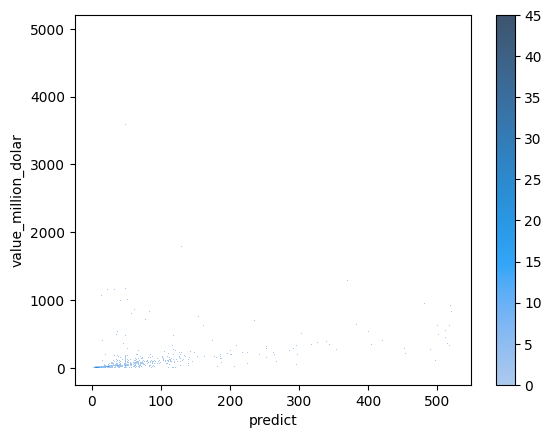

In [38]:
import seaborn
seaborn.histplot(subset[["predict","value_million_dolar"]],x="predict",y="value_million_dolar",cbar=True,bins=1000)

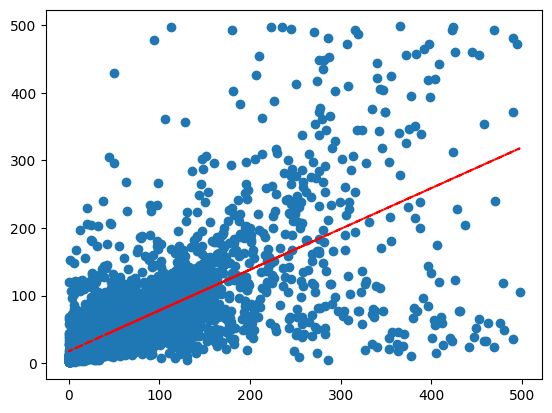

In [32]:
plt.scatter(subset["value_million_dolar"],subset["predict"])
z = np.polyfit(subset["value_million_dolar"], subset["predict"], 1)
p = np.poly1d(z)
plt.plot(subset["value_million_dolar"],p(subset["value_million_dolar"]),"r--")